In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Dataset generation function
def generate_synthetic_data(num_samples=4000):
    np.random.seed(42)
    
    # Generating synthetic features (SpO2 and HeartRate)
    SpO2 = np.random.uniform(90, 100, num_samples)  # Simulate SpO2 values between 90 and 100
    HeartRate = np.random.uniform(50, 120, num_samples)  # Simulate HeartRate between 50 and 120
    
    # Simulating Labels (0: Normal, 1: Mild Hypoxia, 2: Severe Hypoxia)
    labels = np.random.choice([0, 1, 2], num_samples)
    
    # Create a DataFrame
    data = pd.DataFrame({
        'SpO2': SpO2,
        'HeartRate': HeartRate,
        'Label': labels
    })
    
    return data

# Preprocess the data (normalizing and reshaping)
def preprocess_data(data):
    X = data[["SpO2", "HeartRate"]].values
    y = to_categorical(data["Label"].values, num_classes=3)  # One-hot encode the labels
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Padding to make the number of elements fit ResNet input size
    # We want to get a shape of (224, 224, 3)
    
    # Ensure X_train and X_test have 150528 features (224 * 224 * 3)
    target_size = 224 * 224 * 3
    total_elements_train = X_train.shape[1]
    total_elements_test = X_test.shape[1]
    
    # Check if the current size is already multiple of target_size, else pad
    padding_needed_train = target_size - total_elements_train % target_size
    padding_needed_test = target_size - total_elements_test % target_size
    
    X_train = np.pad(X_train, ((0, 0), (0, padding_needed_train)), mode='constant')
    X_test = np.pad(X_test, ((0, 0), (0, padding_needed_test)), mode='constant')
    
    print(f"X_train shape before reshaping: {X_train.shape}")
    
    # Reshape data into (224, 224, 3)
    X_train = np.reshape(X_train, (-1, 224, 224, 3))  
    X_test = np.reshape(X_test, (-1, 224, 224, 3))
    
    print(f"X_train shape after reshaping: {X_train.shape}")
    
    return X_train, X_test, y_train, y_test

# Example usage
data = generate_synthetic_data(num_samples=1000)  # Generate synthetic data with 1000 samples
X_train, X_test, y_train, y_test = preprocess_data(data)



X_train shape before reshaping: (800, 150528)
X_train shape after reshaping: (800, 224, 224, 3)


In [2]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
def build_model(input_shape=(224, 224, 3)):
    # Load pre-trained ResNet152 model, excluding the top layer
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers on top of ResNet152
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout to avoid overfitting
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes for classification
    
    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Example usage: build the model
model = build_model()
model.summary()  # View model architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 58,896,259 (224.67 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [3]:
# Train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    history = model.fit(
        X_train, y_train, 
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )
    return history

# Example usage: Train the model
history = train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.3238 - loss: 1.6693 - val_accuracy: 0.2950 - val_loss: 1.1832
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.3364 - loss: 1.4141 - val_accuracy: 0.2950 - val_loss: 1.1349
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 0.3320 - loss: 1.2166 - val_accuracy: 0.3400 - val_loss: 1.1091
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 182s 7s/step - accuracy: 0.3664 - loss: 1.1686 - val_accuracy: 0.3650 - val_loss: 1.0974
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.3628 - loss: 1.1415 - val_accuracy: 0.3400 - val_loss: 1.1005
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.3208 - loss: 1.1398 - val_accuracy: 0.3400 - val_loss: 1.0999
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.3229 - loss: 1.1161 - val_accuracy: 0.2950 - val_loss: 1.0987
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 213s 9s/step - accuracy: 0.3201 - loss: 1.1194 - val_accuracy: 0.2950 - v

In [4]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

# Example usage: Evaluate the model
evaluate_model(model, X_test, y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.3278 - loss: 1.0973
Test Loss: 1.0973302125930786
Test Accuracy: 0.3400000035762787


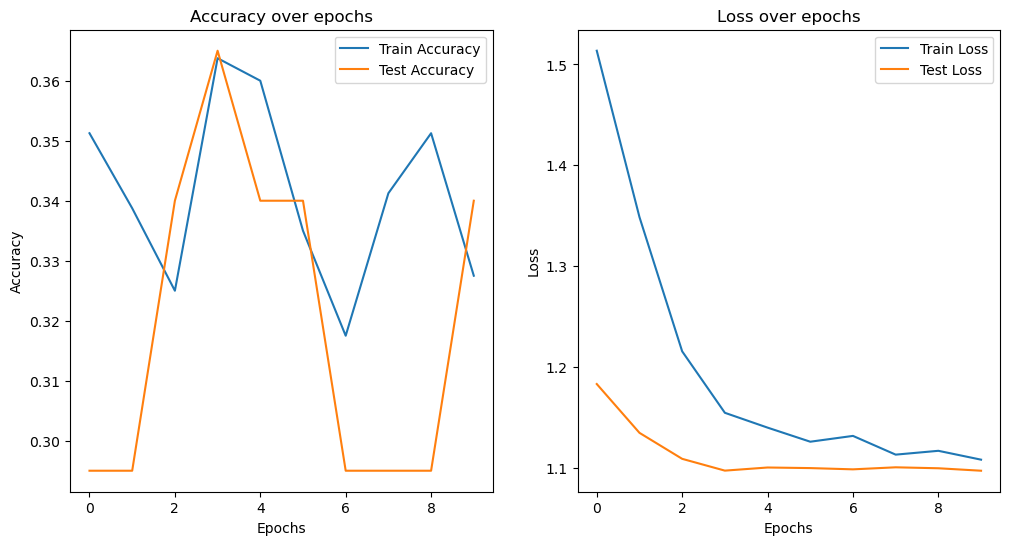

In [5]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage: Plot history
plot_history(history)


In [9]:
# Save the trained model
def save_model(model, model_name="baby_monitoring_model.h5"):
    model.save(model_name)
    print(f"Model saved as {model_name}")

# Example usage: Save the model
save_model(model)


Model saved as baby_monitoring_model.h5


In [10]:
from tensorflow.keras.models import load_model

# Load the saved model
def load_trained_model(model_name="baby_monitoring_model.h5"):
    model = load_model(model_name)
    return model

# Example usage: Load and predict using the saved model
loaded_model = load_trained_model()
predictions = loaded_model.predict(X_test)
print(predictions)


7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step
[[0.34039602 0.33590627 0.3236977 ]
 [0.34039596 0.33589715 0.32370698]
 [0.34039596 0.3359033  0.3237007 ]
 [0.34039745 0.33589286 0.32370958]
 [0.34039563 0.3358979  0.32370645]
 [0.34039557 0.33589607 0.32370842]
 [0.34039634 0.3359016  0.32370207]
 [0.34039575 0.33590195 0.32370234]
 [0.34039783 0.33589444 0.3237078 ]
 [0.34039554 0.3359054  0.32369912]
 [0.34039402 0.33590853 0.3236975 ]
 [0.34039596 0.33589357 0.32371035]
 [0.34039682 0.33589467 0.3237085 ]
 [0.3403973  0.33589593 0.32370678]
 [0.34039727 0.33589792 0.32370484]
 [0.34039778 0.33589572 0.3237065 ]
 [0.3403942  0.33590376 0.32370204]
 [0.34039778 0.33589527 0.32370698]
 [0.3403966  0.33590132 0.32370213]
 [0.3403974  0.33590853 0.32369414]
 [0.34039488 0.3359018  0.3237033 ]
 [0.34039572 0.33589903 0.32370526]
 [0.34039763 0.3359082  0.3236942 ]
 [0.34039664 0.3359011  0.32370228]
 [0.34039694 0.33589363 0.32370946]
 [0.34039634 0.33589345 0.32371014]
 [0.3403942  0.33591327 0.3